# Hakai Profile QA/QC Development Tool
This jupyter notebook is a flexible tool used for testing and improving Hakai's QA/QCing workflow of the its CTD profile data. 

The tool can load Hakai's CTD dataset and apply default tests already applied. Those tests can be modified by the user to tests different thresholds. Other tests can be added too!

## Let's load all the python packages we need
Some of the pacakges are available through Pypi while others aren't. We also load the hakai_qc main branch here too.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load local modules
!pip install C:\Users\jessy\Documents\repositories\hakai-profile-qaqc
import hakai_qc

# Get External packages
try:
    from hakai_api import Client
    from ioos_qc.config import QcConfig
    from pyproj import Geod
    import gsw
except:
    # Install Hakai API Python Client
    !pip install git+https://github.com/HakaiInstitute/hakai-api-client-python.git
    from hakai_api import Client

    # Install ioos_qc
    !pip install git+https://github.com/ioos/ioos_qc.git
    from ioos_qc.config import QcConfig
    
    # Extra packages that exist on Pypi
    !pip install pyproj
    !pip install gsw
    
    # Load local modules
    !pip install https://github.com/HakaiInstitute/hakai-profile-qaqc.git
    import hakai_qc


Processing c:\users\jessy\documents\repositories\hakai-profile-qaqc
  Created wheel for hakai-qc: filename=hakai_qc-0.0.1-py3-none-any.whl size=4313 sha256=436fdb2be84a73089e8ce1bcf6be1e0a5370208801d96fbd4f929640357ca525
  Stored in directory: c:\users\jessy\appdata\local\pip\cache\wheels\55\18\61\69fc4115dcf76e252c05cf8b4ae3ef890d57aaec5f79ea8440
Successfully built hakai-qc
  Attempting uninstall: hakai-qc
    Found existing installation: hakai-qc 0.0.1
    Uninstalling hakai-qc-0.0.1:
      Successfully uninstalled hakai-qc-0.0.1


## Import data from the Hakai CTD Profile Database and Hakai List of Stations
The Hakai Station Master List is based on a CSV output of the [Hakai Oceanography Master Stations Map and Data](https://hakai.maps.arcgis.com/apps/webappviewer/index.html?id=38e1b1da8d16466bbe5d7c7a713d2678). Missing sites should be added to the master list in order to applied all the different tests.

In [2]:
# Load Hakai Station List
hakai_stations = hakai_qc.get.hakai_stations()

Now, let's get some data from the Hakai CTD Processed Data Database 

In [6]:
# Get Hakai CTD Data Download through the API
# Let's just get the data from QU39
filterUrl = 'station=QU39&status!=MISCAST&limit=20000'
df, url = hakai_qc.get.hakai_ctd_data(filterUrl)
print(str(len(df))+' records found')

# Regroup profiles and sort them by pressure
group_variables = ['device_model','device_sn','ctd_file_pk','ctd_cast_pk','direction_flag']
df = df.sort_values(by=group_variables+['pressure'])

# Get Derived Variables
df = hakai_qc.utils.derived_ocean_variables(df)
df = df.replace(-9.99E-29,pd.NA) # TODO those flag values from Seabird should be flagged
# Just show the first few lines to have a look
df.head() # Show the top of the data frame

Please go here and authorize:
https://hecate.hakai.org/api/auth/oauth2?response_type=code&client_id=289782143400-1f4r7l823cqg8fthd31ch4ug0thpejme.apps.googleusercontent.com&state=J86yz9i2Z47z3yGfvuA909RV7SLWCq



Paste the full redirect URL here:
 https://hecate.hakai.org/api/auth/oauth2/callback?state=J86yz9i2Z47z3yGfvuA909RV7SLWCq&code=4/0AY0e-g43nPsxK3wLHYlwxRqpMZpwnh2L-bmDB7I7ew5bgm7l93gns0hwidTuKjw_f_yvsw&scope=email%20profile%20openid%20https://www.googleapis.com/auth/userinfo.email%20https://www.googleapis.com/auth/userinfo.profile&authuser=0&hd=hakai.org&prompt=none


20000 records found


C:\Users\jessy\Anaconda3\lib\site-packages\gsw\_wrapped_ufuncs.py:696: RuntimeWarning: invalid value encountered in ct_from_t
  return _gsw_ufuncs.ct_from_t(SA, t, p)


,ctd_file_pk,ctd_cast_pk,hakai_id,ctd_data_pk,filename,device_model,device_sn,device_firmware,file_processing_stage,work_area,...,cast_type,sensors_submerged,water_depth_m,soak_start,soak_end,weather,absolute salinity,conservative temperature,density,sigma0
0,2183,7202,080217_2016-03-07T17:23:34.333Z,9475691,080217_20160307_1719,RBRmaestro,080217,12.03,8_rbr_processed,QUADRA,...,None,None,None,None,None,None,26.883805,8.406325,1020.776815,20.772209
1,2183,7202,080217_2016-03-07T17:23:34.333Z,9475692,080217_20160307_1719,RBRmaestro,080217,12.03,8_rbr_processed,QUADRA,...,None,None,None,None,None,None,26.879740,8.414078,1020.777237,20.768025
2,2183,7202,080217_2016-03-07T17:23:34.333Z,9475693,080217_20160307_1719,RBRmaestro,080217,12.03,8_rbr_processed,QUADRA,...,None,None,None,None,None,None,26.881705,8.414060,1020.783372,20.769554
3,2183,7202,080217_2016-03-07T17:23:34.333Z,9475694,080217_20160307_1719,RBRmaestro,080217,12.03,8_rbr_processed,QUADRA,...,None,None,None,None,None,None,26.883166,8.414554,1020.789049,20.770624
4,2183,7202,080217_2016-03-07T17:23:34.333Z,9475695,080217_20160307_1719,RBRmaestro,080217,12.03,8_rbr_processed,QUADRA,...,None,None,None,None,None,None,26.885130,8.414434,1020.795197,20.772167


In [56]:
df = df.replace(-9.99E-29,pd.NA)

## Test Configuration
We first import the different tests that applied as of now to the Hakai Dataset. You can also add new tests by adding a related dictionary which follow the structure presented below. For more information on the different tests available, have a look at the [ioos_qc webpage](https://ioos.github.io/ioos_qc/api/ioos_qc.html).

In [57]:
# Load default test parameters used right now!
qc_config = hakai_qc.config.hakai_ctd_profile.hakai_ctd_profile_parameters()

# If you want to add or modify some of the tests do it here
#ex: let's add for the range of fluorescence 
qc_config['flc']= {'qartod': {
                        'gross_range_test': {   
                            "suspect_span": [0, 70],
                            "fail_span": [-.5, 100],
                        },
    
                        "aggregate": {}    
                        }
                   }


## Apply Tests

In [58]:
# Run all the tests on each available profiles
df_out = hakai_qc.run.tests_on_profiles(df,hakai_stations,qc_config)

QAQC QU39
position
{'qartod': {'location_test': {'bbox': [-125.14107014641213, 50.00372871260039, -125.05732985358786, 50.05767116137374], 'range': 3000}, 'aggregate': {}}}
pressure
{'qartod': {'gross_range_test': {'suspect_span': [0, 280.83826311944904], 'fail_span': [0, 294.2115137441847], 'maximum_suspect_depth_ratio': 1.05, 'maximum_fail_depth_ratio': 1.1}, 'aggregate': {}}}
depth
{'qartod': {'gross_range_test': {'suspect_span': [0, 278.25], 'fail_span': [0, 291.5], 'maximum_suspect_depth_ratio': 1.05, 'maximum_fail_depth_ratio': 1.1}, 'aggregate': {}}}
dissolved_oxygen_ml_l
{'qartod': {'gross_range_test': {'fail_span': [0, 12], 'suspect_span': [1, 10]}, 'rate_of_change_test': {'threshold': 1}, 'spike_test': {'suspect_threshold': 0.5, 'fail_threshold': 1}, 'attenuated_signal_test': {'suspect_threshold': 0.5, 'fail_threshold': 0.2, 'check_type': 'range'}, 'aggregate': {}}}
rinko_do_ml_l
{'qartod': {'gross_range_test': {'fail_span': [0, 12], 'suspect_span': [1, 10]}, 'rate_of_change_

## Review Results
Let's filter all the data that actually got flagged and keep only the downcast.

In [59]:
# Get Variables to plot
variables_to_plot = list(set(qc_config.keys())-set(['position','depth','pressure']))

variables_to_plot = ["sigma0","salinity","dissolved_oxygen_ml_l"]

# Review Flagged data
flag_columns = [var+'_qartod_aggregate' for var in variables_to_plot]
flagged_hakai_id = df[((df.filter(items=flag_columns)>1) 
                       & (df.filter(items=flag_columns)!=9)).any(axis=1)]['hakai_id'].unique()
               

# Tell me how many there is
print(str(len(flagged_hakai_id))+' profiles were flagged')

15 profiles were flagged


Present the results in a some figures!

C:\Users\jessy\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # This is added back by InteractiveShellApp.init_path()
C:\Users\jessy\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  del sys.path[0]


['sigma0', 'salinity', 'dissolved_oxygen_ml_l']

<Figure size 432x288 with 0 Axes>

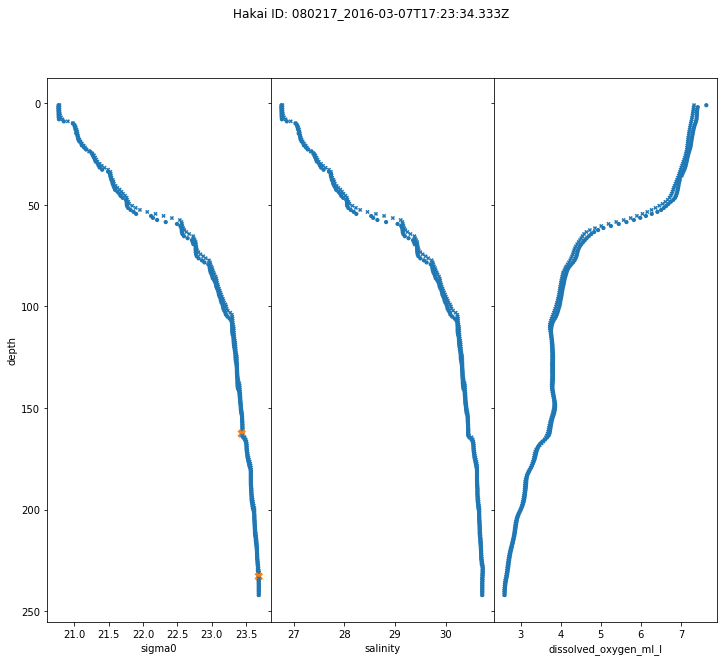

<Figure size 432x288 with 0 Axes>

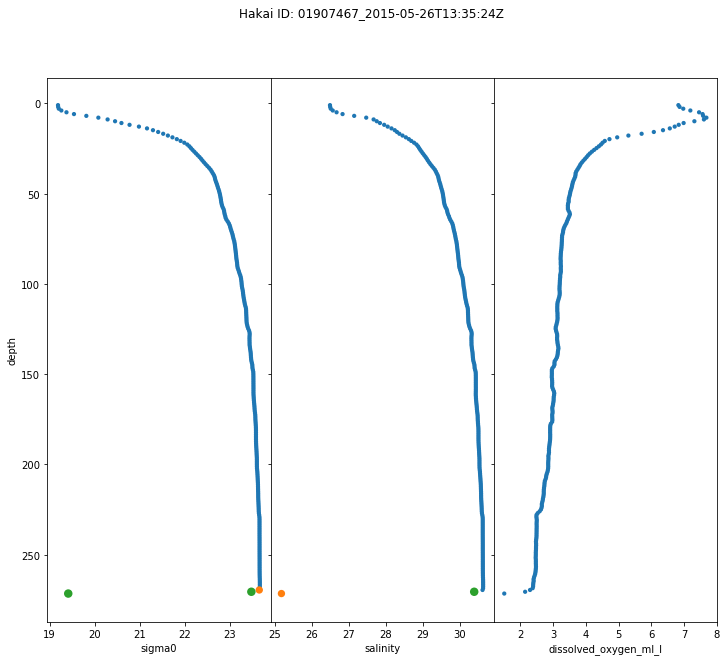

<Figure size 432x288 with 0 Axes>

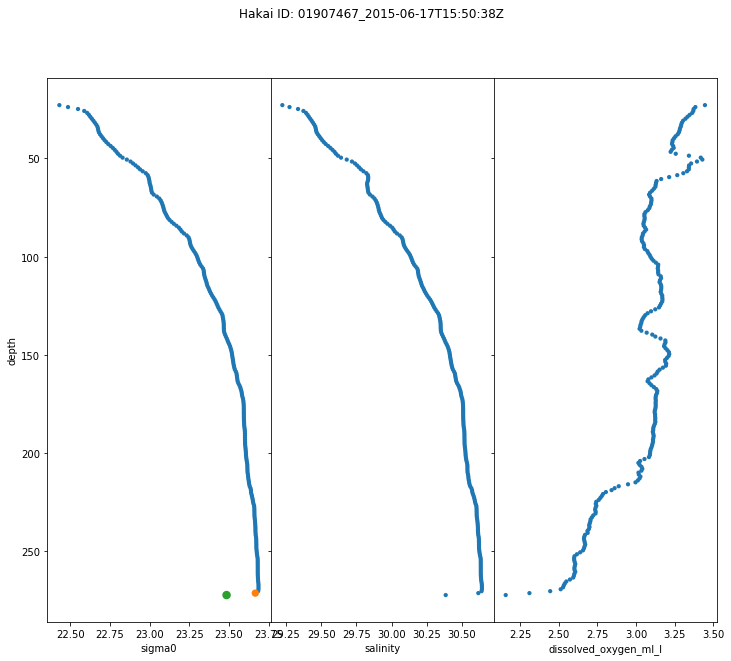

<Figure size 432x288 with 0 Axes>

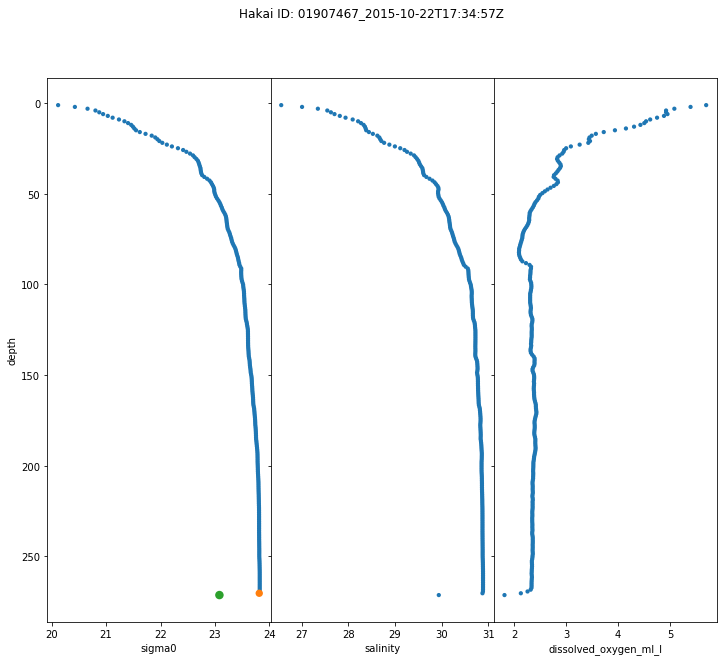

<Figure size 432x288 with 0 Axes>

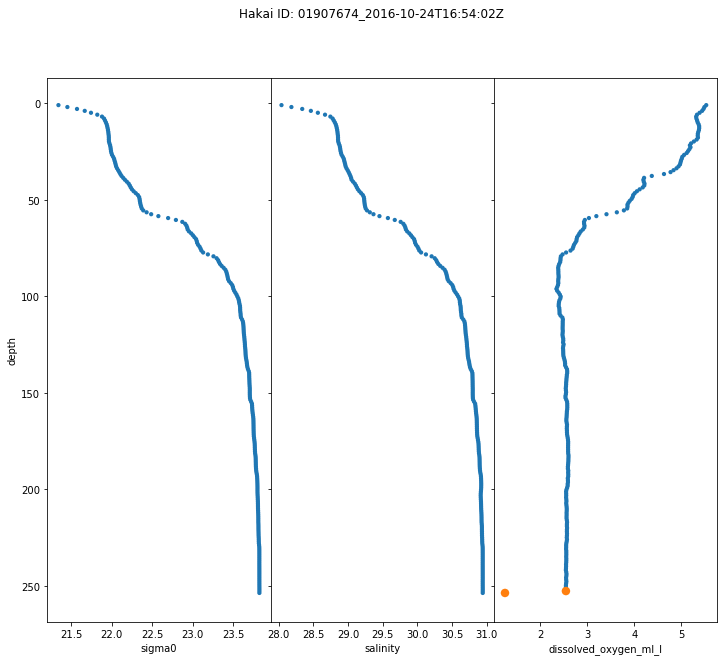

<Figure size 432x288 with 0 Axes>

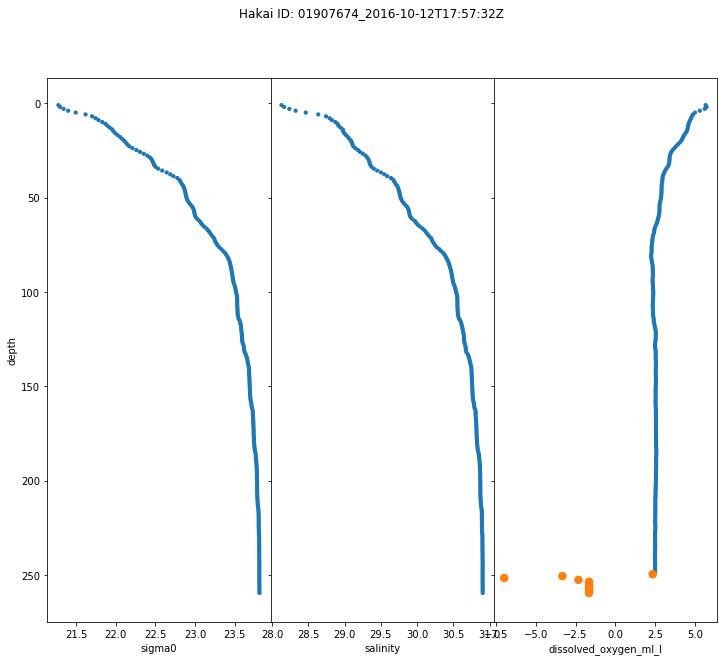

<Figure size 432x288 with 0 Axes>

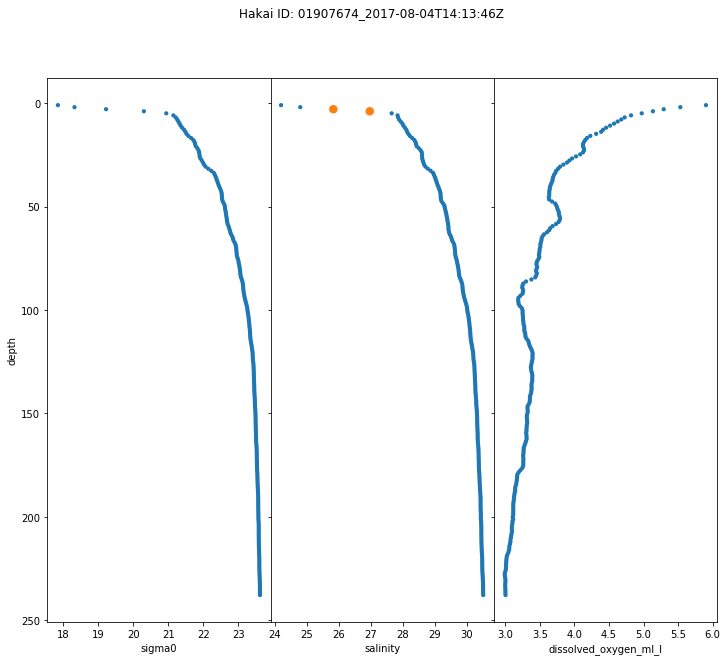

<Figure size 432x288 with 0 Axes>

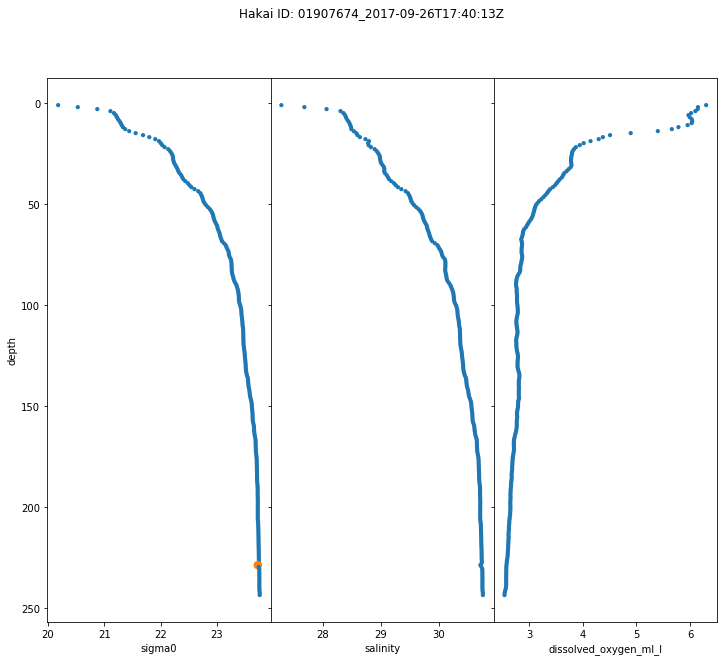

<Figure size 432x288 with 0 Axes>

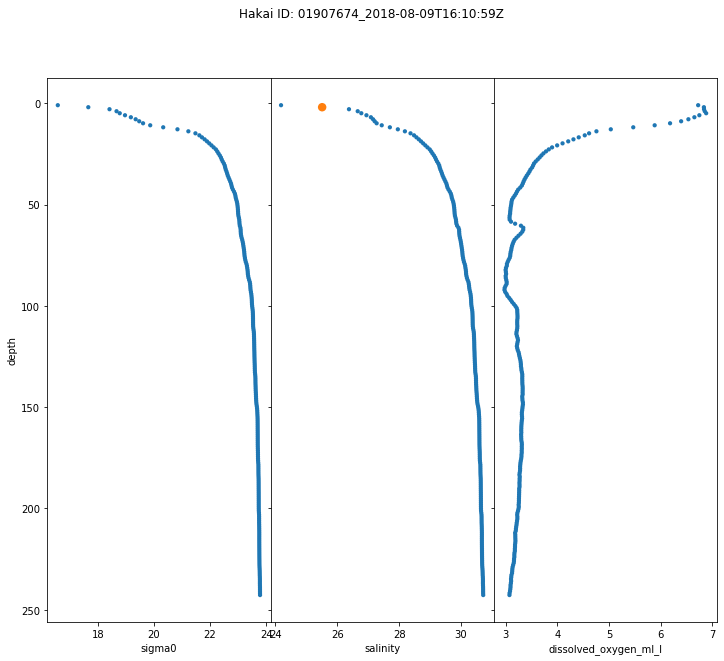

<Figure size 432x288 with 0 Axes>

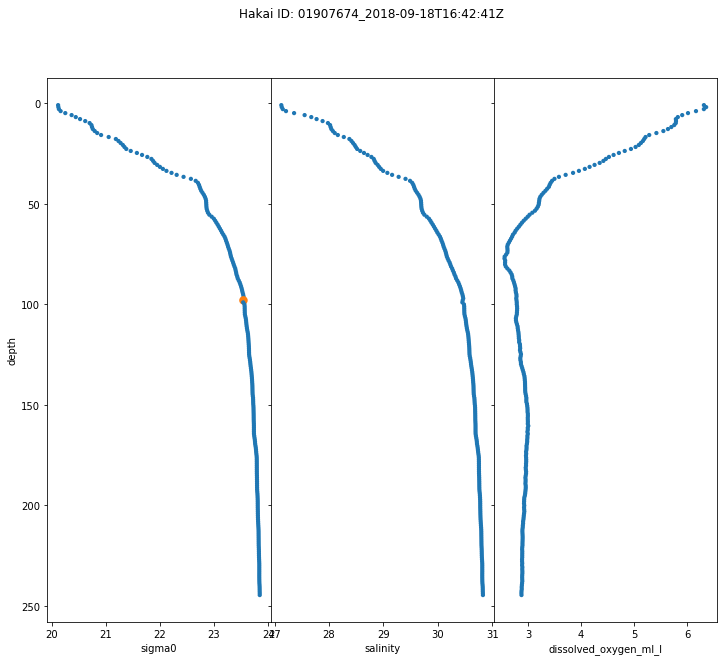

<Figure size 432x288 with 0 Axes>

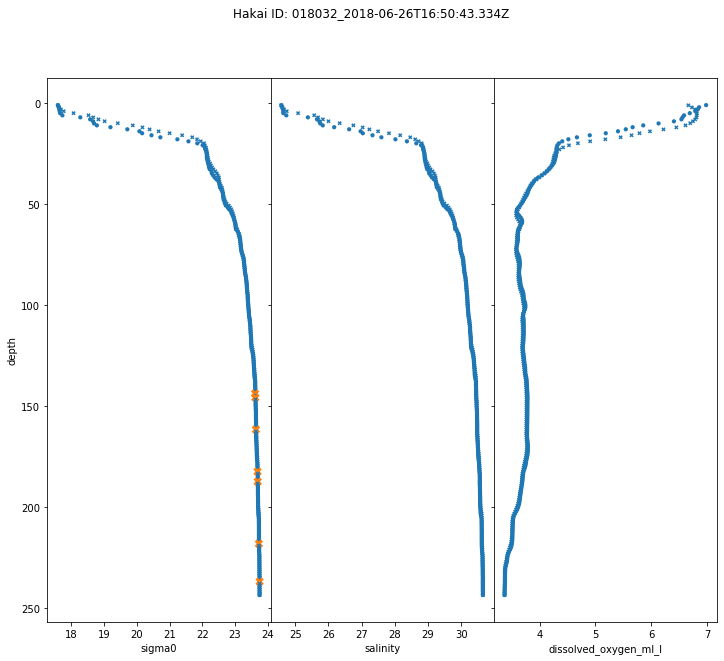

<Figure size 432x288 with 0 Axes>

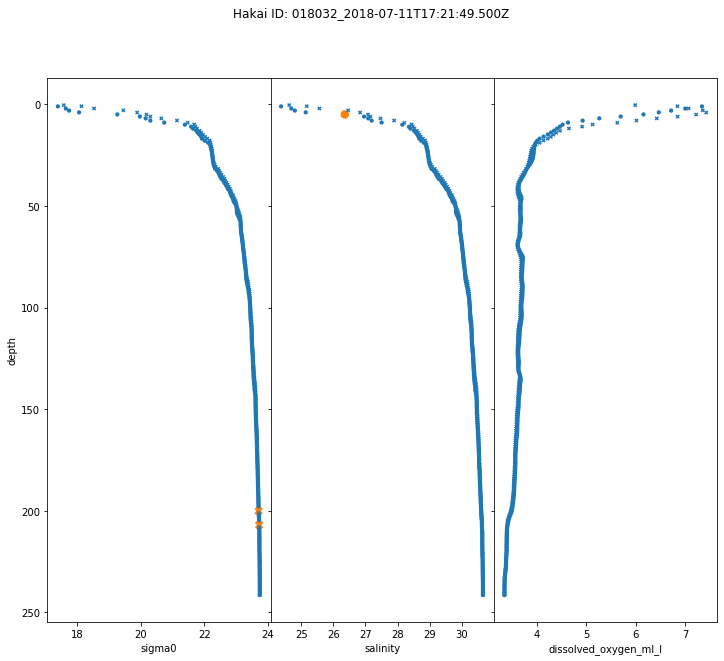

<Figure size 432x288 with 0 Axes>

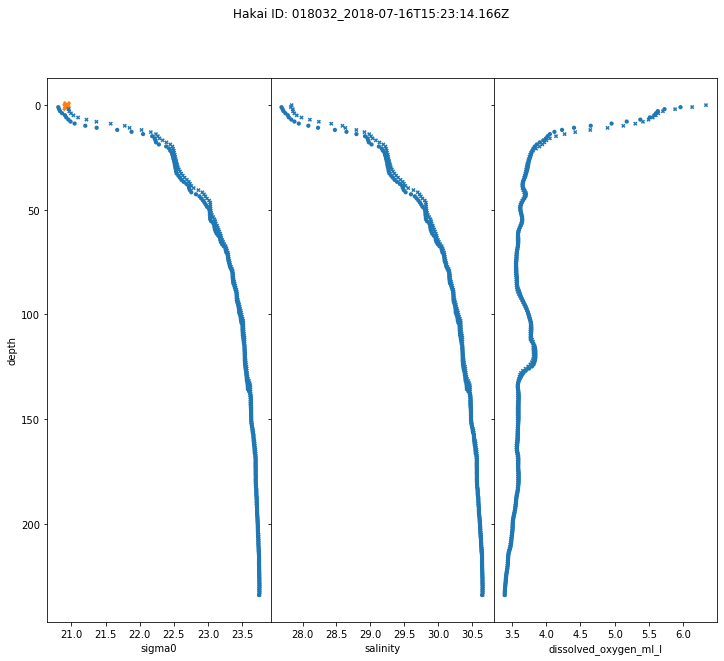

<Figure size 432x288 with 0 Axes>

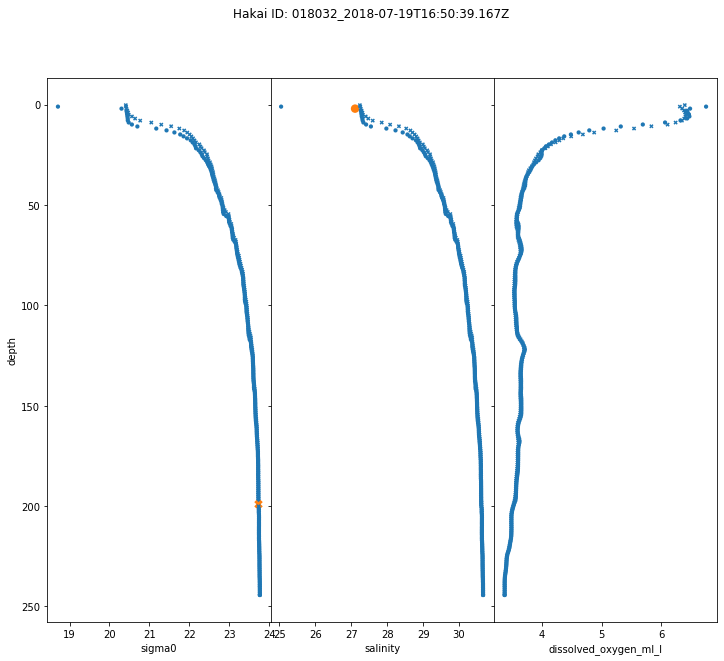

<Figure size 432x288 with 0 Axes>

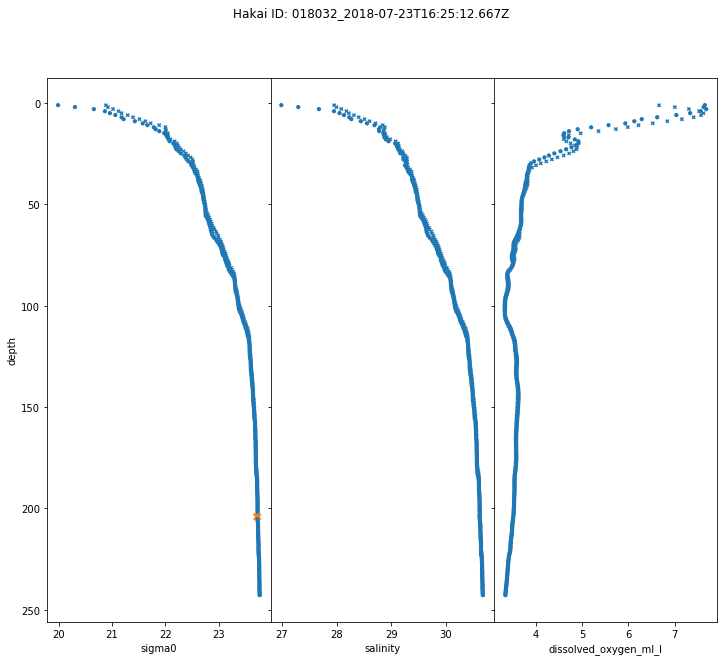

In [60]:
plot_n_profiles = 20
if len(flagged_hakai_id)>plot_n_profiles:
    temp_flagged_hakai_id = flagged_hakai_id[:plot_n_profiles]
else:
    temp_flagged_hakai_id = flagged_hakai_id
        
    

# Loop  through each profiles and variable and create plot
for hakai_id in temp_flagged_hakai_id:
    plt.figure()
    fig,axs = plt.subplots(1,len(variables_to_plot),
                          sharex=False,sharey=True)
    fig.set_figwidth(4*len(variables_to_plot))
    fig.set_figheight(10)
    fig.suptitle('Hakai ID: '+hakai_id)

    axs[0].invert_yaxis()
    
    kk=0
    for variable in variables_to_plot:
        g = sns.scatterplot(data=df[df['hakai_id']==hakai_id],
                            x=variable,y='depth',
                            hue=variable+'_qartod_aggregate', palette='tab10',
                            style='direction_flag',
                            size=variable+'_qartod_aggregate' ,
                            linewidth=0,ax=axs[kk],legend=False)
        kk=kk+1
    plt.subplots_adjust(wspace=0, hspace=0)
variables_to_plot